In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [7]:
# Cloud AutoML
PROJECT_ID = 'automl-exercise-307804'
from google.cloud import automl_v1beta1 as automl
automl_client = automl.AutoMlClient()

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator

## Load Data

In [2]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

## Data Visualization and Scaling

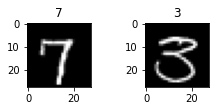

In [17]:
#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(6,8):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

In [19]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)

X_train.shape, X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [21]:
# Feature standardization for better performance
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px


In [22]:
# One hot encoding of labels
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

## Neural Network Architecture

In [23]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)

In [24]:
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

## Linear model

In [25]:
# Model with 
# lambda layer (perform arithmetic (sum, avg, exp)), 
# Flatten (to transform to 1D array)
# Dense (all connected nodes) - 10 nodes to represent each digit (attach softmax to reduce range to 0 to 1)

model= Sequential()
model._name = 'Linear'
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

input shape  (None, 28, 28, 1)
output shape  (None, 10)


In [27]:
# Compile network 
# Defining loss function, optimzer and metrics

from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

from keras.preprocessing import image
gen = image.ImageDataGenerator()

In [28]:
# Cross Validation
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [37]:
%%time
history = model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/3
   40/34020 [..............................] - ETA: 1:31 - loss: 0.3089 - accuracy: 0.9141

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


34020/34020 [==============================] - 2s 49us/step - loss: 0.3061 - accuracy: 0.9118 - val_loss: 0.2897 - val_accuracy: 0.9159
CPU times: user 2.31 s, sys: 275 ms, total: 2.59 s
Wall time: 1.72 s


In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [36]:
#predictions
predictions = model.predict_classes(X_test, verbose=0)
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("Linear.csv", index=False, header=True)

## Fully Connected Model

In [38]:
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model._name = 'Fully_Connected'
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [39]:
fc = get_fc_model()
fc.optimizer.lr=0.01
history = fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

In [41]:
fc.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [42]:
#predictions
predictions = fc.predict_classes(X_test, verbose=0)
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("FC.csv", index=False, header=True)

## Convolutional Neural Network

In [51]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model._name = 'CNN'
    return model

In [52]:
cnn_model= get_cnn_model()
cnn_model.optimizer.lr=0.01
history = cnn_model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                              validation_data=val_batches, validation_steps=val_batches.n)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


34020/34020 [==============================] - 3s 81us/step - loss: 0.2569 - accuracy: 0.9209 - val_loss: 0.1600 - val_accuracy: 0.9556


In [54]:
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 64)          0       

In [56]:
#predictions
predictions = cnn_model.predict_classes(X_test, verbose=0)
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("CNN.csv", index=False, header=True)